## Data cleaning and sanity checks

In this file, missing patterns of datasets are checked, and treatment patterns are analyzed for sanity checks and preparation for further analysis.

### Package, globals and functions

In [ ]:
# uncomment this line to install packages if not already installed
# !pip install numpy, pandas, matplotlib, scikit-learn

In [1]:
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

In [3]:
# function to clean firm_id
def clean_firm_id(firm_id):
    """Cleans the firm_id by stripping spaces, removing trailing '00', and checking format."""
    firm_id = firm_id.strip()
    if firm_id.endswith('00'):
        firm_id = firm_id[:-2]

    # Check if the cleaned firm_id follows the format ABCD-12
    pattern = r'^[A-Z]{4}-\d{2}$'
    if not re.match(pattern, firm_id):
        raise ValueError(f"Invalid firm_id format: {firm_id}")
    return firm_id

# Function to fill missing sales within each firm
def fill_missing_values_with_gp(df, firm_id, sales_column):
    def fill_sales(group):
        # Extract non-missing and missing indices
        non_missing = group[group[sales_column].notnull()]
        missing = group[group[sales_column].isnull()]

        if not missing.empty and len(non_missing) > 1:
            # Prepare data for Gaussian Process
            X_train = non_missing.index.values.reshape(-1, 1)
            y_train = non_missing[sales_column].values
            X_pred = missing.index.values.reshape(-1, 1)

            # Define Gaussian Process with RBF kernel
            kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

            # Fit and predict
            gp.fit(X_train, y_train)
            y_pred, _ = gp.predict(X_pred, return_std=True)

            # Fill missing values
            group.loc[missing.index, sales_column] = y_pred

        return group

    # Apply the function to each firm
    df = df.groupby(firm_id).apply(fill_sales)
    return df

### Data Cleaning & Wrangling

#### Firm Information

In [4]:
# Check for missing data in the firm_info dataframe
firm_info = pd.read_csv('firm_information.csv')
missing_data = firm_info.isnull().sum()
print("Missing data in each column:")
print(missing_data)
firm_info.describe()

# firm_id and firm_name have no missing values and are unique, so we can use them as identifiers

Missing data in each column:
firm_id        0
firm_name      0
firm_sector    0
dtype: int64


,firm_id,firm_name,firm_sector
count,498,498,498
unique,498,498,3
top,AAAI-15,Resorts International Holdings,Retail
freq,1,1,209


Distribution of firm_sector:
firm_sector
Retail         209
Hospitality    149
Fast Food      140
Name: count, dtype: int64


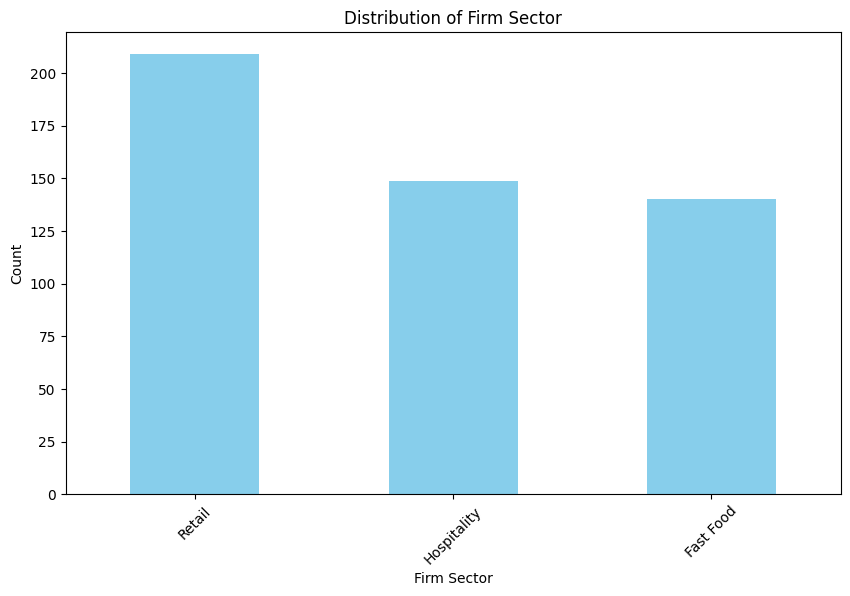

In [5]:
# Check the distribution of the 'firm_sector' column
if 'firm_sector' in firm_info.columns:
    sector_distribution = firm_info['firm_sector'].value_counts()
    print("Distribution of firm_sector:")
    print(sector_distribution)
    plt.figure(figsize=(10, 6))
    sector_distribution.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Firm Sector')
    plt.xlabel('Firm Sector')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


#### Aggregate firm sales

In [6]:
# Check for wrongly represented firm_id in the firm_sales dataframe

# firm id in firm_sales and firm_aux include spaces which need to be stripped, and extra two zeros at the end of firm_id need to be removed
firm_sales = pd.read_csv('aggregate_firm_sales.csv')
firm_sales['firm_id'] = firm_sales['firm_id'].apply(clean_firm_id)
firm_sales = firm_sales.merge(firm_info[['firm_id', 'firm_sector']], on='firm_id', how='left')
missing_data = firm_sales.isnull().sum()
print("Missing data in each column:")
print(missing_data)
firm_sales.describe()

# All firm sector cleaned!
# sales has no negative or extra large values, so we only need to deal with missing values

Missing data in each column:
firm_id           0
date              0
sales_t        2100
firm_sector       0
dtype: int64


,sales_t
count,54546.000000
mean,8633.203241
std,5276.016213
min,504.000000
25%,4266.000000
50%,7978.000000
75%,12003.000000
max,45973.000000


In [ ]:
# Fill in missing values of firm's sales within each firm_sector using Gaussian Process

# Apply the function to firm_sales
scaler = StandardScaler()
firm_sales['sales_t'] = scaler.fit_transform(firm_sales[['sales_t']])
firm_with_filled_sales = fill_missing_values_with_gp(firm_sales, 'firm_id', 'sales_t')
firm_with_filled_sales['sales_t'] = scaler.inverse_transform(firm_with_filled_sales[['sales_t']])

In [ ]:
# save the imputed dataset to a new csv
firm_with_filled_sales.to_csv('firm_sales_with_filled_values.csv', index=False)

#### Auxiliary firm data

In [ ]:
# Check for first month of data after applying the same cleaning and merging process
first = pd.read_csv('./monthly_data/2010_1.csv')
first['firm_id'] = first['firm_id'].apply(clean_firm_id)
first = first.merge(firm_info[['firm_id', 'firm_sector']], on='firm_id', how='left')
missing_data = first.isnull().sum()
print("Missing data in each column:")
print(missing_data)
first.describe()

In [ ]:
# Fill in missing employment, wage bill and revenue
detrend_cols = ['employment_t', 'wage_bill_t', 'revenue_t']
for col in detrend_cols:
    scaler = StandardScaler()
    first[col] = scaler.fit_transform(first[[col]])
    first = fill_missing_values_with_gp(first, 'firm_sector', col)
    first[col] = scaler.inverse_transform(first[[col]])